In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
import cv2 
import pickle
import glob
#from scipy.misc import imread, imresize
from skimage.transform import resize
from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

#file_name = 'calibration.p'
file_name = 'Camera_Calibration/Mobius_Dashcam_Camera_Cal/1920x1080/mobius_dashcam_1920x1080_calibration.p'

with open(file_name, 'rb') as f:   
    mtx, dist = pickle.load(f)

## Useful Functions

In [32]:
# Draws viewing window onto copy of image
def draw_viewing_window(image,viewing_window):
    image_copy = np.copy(image)
    for line in viewing_window:
        for x1,y1,x2,y2 in line:
            cv2.line(image_copy,(x1,y1),(x2,y2),(0,255,0),10)
    return image_copy

# Makes the viewwing window which is used by draw_viewing_window()
def make_viewing_window(bottom_left,top_left,top_right,bottom_right):
    left_line = np.array([[bottom_left[0],bottom_left[1],top_left[0],top_left[1]]])
    top_line = np.array([[top_left[0],top_left[1],top_right[0],top_right[1]]])
    right_line = np.array([[top_right[0],top_right[1],bottom_right[0],bottom_right[1]]])
    bottom_line = np.array([[bottom_right[0],bottom_right[1],bottom_left[0],bottom_left[1]]])
    viewing_window = [left_line,top_line,right_line,bottom_line]

    return viewing_window

# Applies sobel algorithm with respect to x or y axis with thresholded gradient
def abs_sobel_thresh(img, orient='x', sobel_kernel=7, thresh_min=0, thresh_max=255):
    
    
    # Convert to gray-scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take derivative
    if (orient == 'x'):
        sobel = cv2.Sobel(gray, cv2.CV_32F, 1, 0 ,ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_32F, 0, 1,ksize=sobel_kernel)
    
    # Take absolute value of derivative    
    abs_sobel = np.absolute(sobel)
    
    # Convert to 8-bit image (0 - 255)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Make copy of scaled_sobel with all zeros
    sobel_binary = np.zeros_like(scaled_sobel)
    # Make all pixels within threshold range a value of 1
    # Keep all other pixels as 0
    sobel_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    binary_output = sobel_binary
    # binary_output = np.copy(img) # Remove this line
    return binary_output

# Function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def sobel_mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):

    thresh_min = mag_thresh[0]
    thresh_max = mag_thresh[1]
    
    # Convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take derivatives in both x and y direction
    sobelx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=sobel_kernel)
    # Find magnitude of the gradient
    sum_of_squares = np.square(sobelx) + np.square(sobely)
    sobel_mag = np.power(sum_of_squares,0.5)
    # Convert to 8-bit image (0 - 255)
    scaled_sobel = np.uint8(255*sobel_mag/np.max(sobel_mag))
    # Make a copy of sobel_mag with all zeros
    sobel_binary = np.zeros_like(scaled_sobel)
    # Make all pixels within threshold range a value of 1
    # Keep all other pixels as 0
    sobel_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    binary_output = sobel_binary

    return binary_output

# Function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
        
    # Min and Max Threshold Angles
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    # Convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the derivatives with respect to x and y
    sobelx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=sobel_kernel)
    # Take absolute value of derivatives
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # Calculate angle for direction of gradient in radians
    sobel_angle = np.arctan2(abs_sobely,abs_sobelx)
    # Make a copy of sobel_angle with all zeros
    sobel_binary = np.zeros_like(sobel_angle)
    # Apply thresholding
    sobel_binary[(sobel_angle >= thresh_min) & (sobel_angle <= thresh_max)] = 1
    binary_output = sobel_binary
    
    return binary_output

def region_of_interest(gray, limit_look_ahead):
  copy = np.copy(gray) + 1
  #copy[:, :225] = 0 
  copy[650:1080, 800:1500] = 0 
  #copy[0:800, 0:350] = 0
  copy[:int(gray.shape[0]*limit_look_ahead), :] = 0
  return copy 


# Takes in RGB image and applies color and gradient thresholding
def combined_threshold(image, gradx_low=40, gradx_high=255, mag_low=40, mag_high=255, dir_low=0.7, dir_high=1.3, \
                       s_low=140, s_high=255, l_low=40, l_high=255,  l_agr=205, kernel_size=3):
    image_hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S = image_hls[:,:,2]
    S_thresholded = np.zeros_like(S)
    thresh_S = (s_low, s_high)
    S_thresholded[(S >= thresh_S[0]) & (S <= thresh_S[1])] = 1
    
    L = image_hls[:,:,1]
    L_thresholded = np.zeros_like(L)
    thresh_L = (l_low, l_high)
    L_thresholded[(L >=thresh_L[0]) & (L <= thresh_L[1])] = 1
    thresh_L_agr = l_agr
    L_thresholded2 = np.zeros_like(L)
    L_thresholded2[L>=thresh_L_agr] = 1
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=kernel_size, thresh_min=gradx_low,
                             thresh_max=gradx_high)
    # I did not use grady in the final output
    grady = abs_sobel_thresh(birds_eye_image, orient='y', sobel_kernel=7, thresh_min=5, thresh_max=255)
    mag_binary = sobel_mag_thresh(image, sobel_kernel=kernel_size, mag_thresh=(mag_low,mag_high))
    dir_binary = dir_threshold(image,sobel_kernel=kernel_size,thresh=(0.7,1.3))

    combined = np.zeros_like(dir_binary)
    """
    combined[(((gradx == 1)) | \
             ((mag_binary == 1) & (dir_binary == 1)) \
              | (S_thresholded == 1)) ] = 1
    """
    
    combined[((mag_binary == 1) & (dir_binary == 1) & (gradx == 1)) | \
             (((S_thresholded == 1) & (L_thresholded == 1)) | (L_thresholded2 == 1))] = 1
    #combined = np.logical_and(combined,region_of_interest(combined,limi)).astype(np.uint8)
    
    return combined


# image is an undistorted image
def apply_birdseye(image,source_points,dest_points):
    
    source_points = np.asarray(source_points)
    dest_points = np.asarray(dest_points)
    M = cv2.getPerspectiveTransform(source_points,dest_points)
    Minv = cv2.getPerspectiveTransform(dest_points,source_points)
    img_size = (image.shape[1],image.shape[0])

    birds_eye_image = cv2.warpPerspective(image, M, img_size,
                                          flags=cv2.INTER_LINEAR)

    # Applying Combined Color and Gradient Thresholding to Birds Eye View Image
    #combined = combined_threshold(birds_eye_image,kernel_size=11)
    
    
    #return combined
    return birds_eye_image
print('done')    

done


## Undistorting the Image

len(image_paths):  9


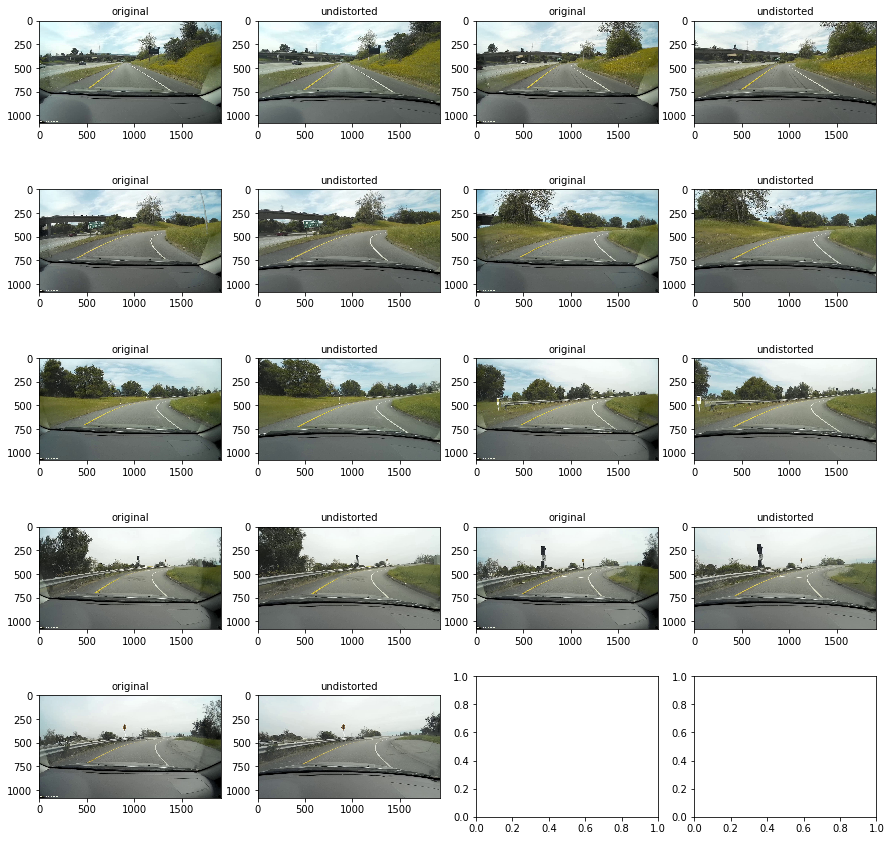

In [5]:
image_paths = glob.glob('Real_Car_Images_And_Videos/Bay_Area_Test_Images/*.jpg')
print("len(image_paths): ", len(image_paths))

image = mpimg.imread(image_paths[0])
image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)

f, axs = plt.subplots(len(image_paths)//2+1,4, figsize=(15,15))
axs = axs.ravel()
for i,image_path in enumerate(image_paths):
    image = mpimg.imread(image_path)
    image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    axs[i*2].imshow(image)
    axs[i*2].set_title('original',fontsize=10)
    axs[i*2+1].imshow(image_undistorted)
    axs[i*2+1].set_title('undistorted',fontsize=10)

## Converting to BirdsEye View

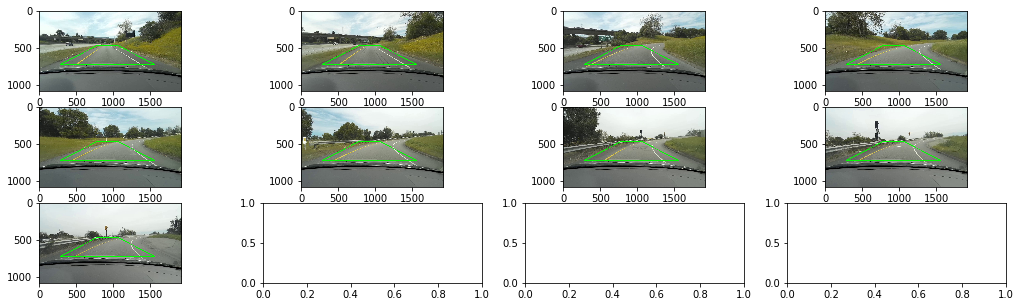

In [6]:
# Defining my source points

"""
# source points for udacity video
src_bottom_left = [580,460]
src_top_left = [205,720]
src_top_right = [1100,720]
src_bottom_right = [703,460]
"""
# source points for mobius 1920x1080
src_top_left = [790,460]
src_bottom_left = [290,720]
src_bottom_right = [1550,720]
src_top_right = [1050,460]
source_points = np.float32([src_top_left,src_bottom_left,src_bottom_right,
                 src_top_right])
src_viewing_window = make_viewing_window(src_bottom_left,src_top_left,src_top_right,src_bottom_right)
f, axs = plt.subplots(3, 4, figsize=(18,5))
axs = axs.ravel()
count = 0
for i,image_path in enumerate(image_paths):
    image = mpimg.imread(image_path)
    image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    image_copy = draw_viewing_window(image_undistorted,src_viewing_window)
    axs[count].imshow(image_copy)
    count += 1
    


## Defining Destination Points

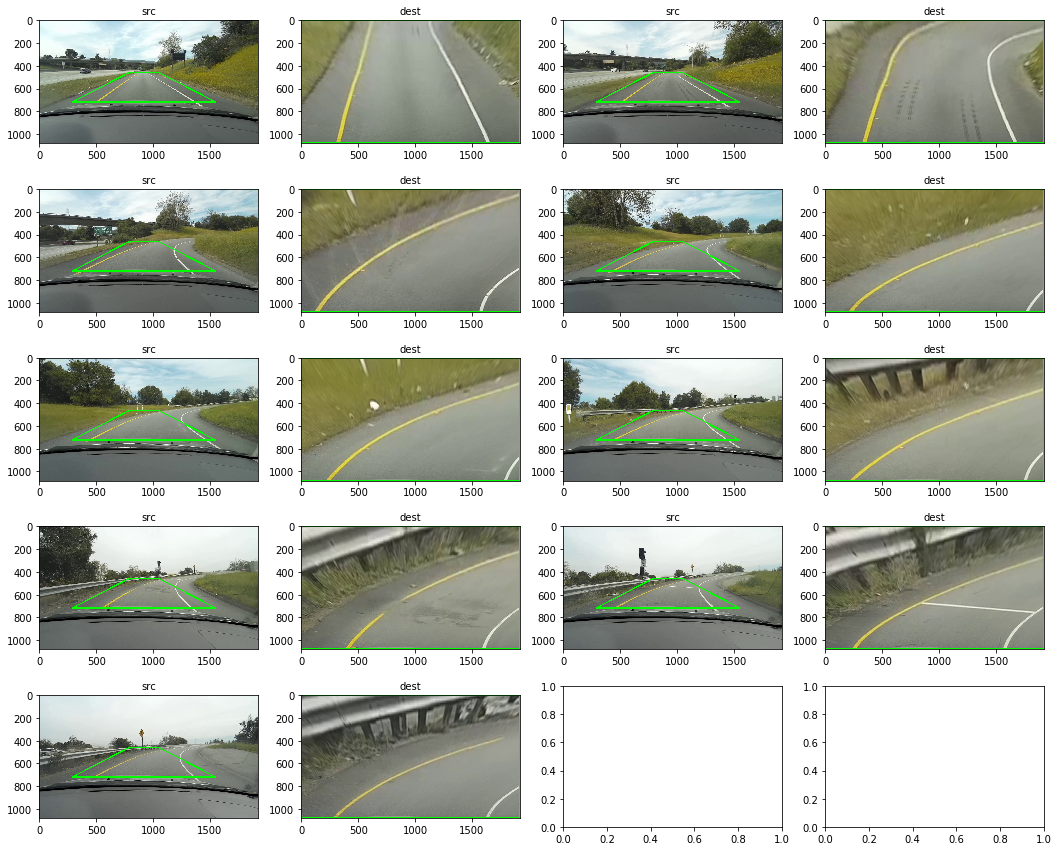

In [7]:
# Defining my destination points
"""
# destination points for udacity video
dest_top_left = [320,0]
dest_bottom_left = [320,720]
dest_bottom_right = [960,720]
dest_top_right = [960,0]
"""

left = 0
right = 1920
bottom = 0
top = 1080
dest_top_left = [left,bottom]
dest_bottom_left = [left,top]
dest_bottom_right = [right,top]
dest_top_right = [right,bottom]
dest_points = np.float32([dest_top_left,dest_bottom_left,dest_bottom_right,
                          dest_top_right])

M = cv2.getPerspectiveTransform(source_points,dest_points)
Minv = cv2.getPerspectiveTransform(dest_points,source_points)
img_size = (image.shape[1],image.shape[0])
dest_viewing_window = make_viewing_window(dest_bottom_left,dest_top_left,dest_top_right,dest_bottom_right)

f, axs = plt.subplots(5, 4, figsize=(18,15))
axs = axs.ravel()
count = 0
for image_path in image_paths:
    image = mpimg.imread(image_path)
    image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    birds_eye_image = cv2.warpPerspective(image_undistorted, M, img_size,
                                      flags=cv2.INTER_LINEAR)
    src_image_copy = draw_viewing_window(image_undistorted,src_viewing_window)
    dest_image_copy = draw_viewing_window(birds_eye_image,dest_viewing_window)
    axs[count*2].imshow(src_image_copy)
    axs[count*2].set_title('src',fontsize=10)
    axs[count*2+1].imshow(dest_image_copy)
    axs[count*2+1].set_title('dest',fontsize=10)                                  
    count += 1

## Apply birdseye view and color and gradient thresholding

i:  0
i:  1
i:  2
i:  3
i:  4
i:  5
i:  6
i:  7
i:  8


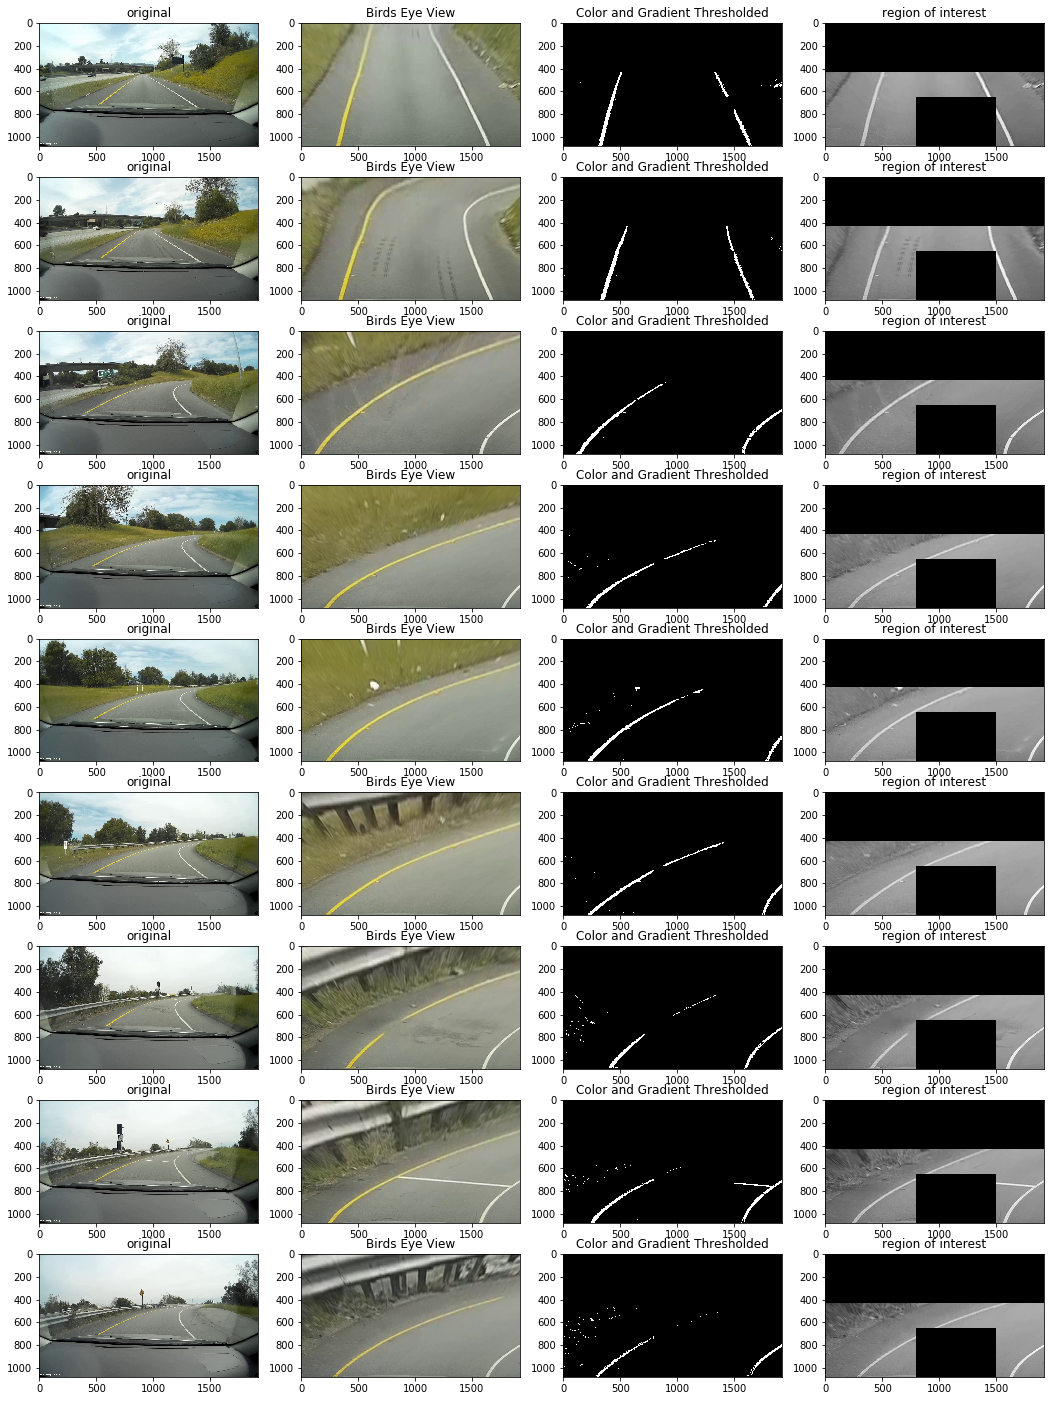

In [33]:
f, axs = plt.subplots(9, 4, figsize=(18,25))
axs = axs.ravel()
count = 0
for i,image_path in enumerate(image_paths):
    print('i: ',i)
    image = mpimg.imread(image_path)

    image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    source_points = np.asarray(source_points)
    dest_points = np.asarray(dest_points)
    M = cv2.getPerspectiveTransform(source_points,dest_points)
    Minv = cv2.getPerspectiveTransform(dest_points,source_points)
    img_size = (image.shape[1],image.shape[0])
    birds_eye_image = cv2.warpPerspective(image_undistorted, M, img_size,
                                          flags=cv2.INTER_LINEAR)
    # Applying Combined Color and Gradient Thresholding to Birds Eye View Image
    #combined = abs_sobel_thresh(birds_eye_image, orient='y', sobel_kernel=7, thresh_min=110, thresh_max=255)
    combined = combined_threshold(birds_eye_image, gradx_low=40, gradx_high=255, mag_low=40, mag_high=255, dir_low=0.7, dir_high=1.3, \
                       s_low=100, s_high=255, l_low=100, l_high=255,  l_agr=205, kernel_size=3)
    limit_look_ahead = 0.4
    combined = np.logical_and(combined,region_of_interest(combined,limit_look_ahead=limit_look_ahead)).astype(np.uint8)
    
    gray = cv2.cvtColor(birds_eye_image, cv2.COLOR_RGB2GRAY)
    gray = region_of_interest(gray,limit_look_ahead)
    
    #combined = apply_birdseye_and_thresholding(image,source_points,dest_points)
    axs[count*4].imshow(image)
    axs[count*4].set_title('original')
    axs[count*4+1].imshow(birds_eye_image)
    axs[count*4+1].set_title('Birds Eye View')
    axs[count*4+2].imshow(combined,cmap='gray')
    axs[count*4+2].set_title('Color and Gradient Thresholded')
    axs[count*4+3].imshow(gray,cmap='gray')
    axs[count*4+3].set_title('region of interest')
    
    count += 1
    
plt.show()


## Put Everything into One Function

/home/adam/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/adam/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


process_time 0:  0.9915933609008789


/home/adam/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/adam/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


process_time 1:  1.1071009635925293


/home/adam/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/adam/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


process_time 2:  0.8673286437988281


/home/adam/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/adam/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


process_time 3:  0.743736982345581


/home/adam/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/adam/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


process_time 4:  0.8009498119354248


/home/adam/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/adam/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


process_time 5:  0.7641122341156006


/home/adam/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/adam/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


process_time 6:  0.8304970264434814


/home/adam/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/adam/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


process_time 7:  0.8560001850128174


/home/adam/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/adam/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


process_time 8:  0.748790979385376


"\nf, axs = plt.subplots(num_pictures,5,figsize=(10,30))\naxs = axs.ravel()\n\nfor i,image_path in enumerate(image_paths):\n    image = mpimg.imread(image_path)\n    result,image_undistorted,best_fit,windows,left_fitx,right_fitx,ploty,binary_warped = process_image(image)\n    #ploty = [i for i in ploty if i <= 480*2.5]\n    #length = len(ploty)\n    #lift_fitx = left_fitx[:length]\n    #right_fitx = right_fitx[:length]\n    axs[i*5].imshow(image_undistorted)\n    axs[i*5+1].imshow(binary_warped)\n    axs[i*5+2].imshow(windows)\n    axs[i*5+3].imshow(best_fit)\n    axs[i*5+3].plot(left_fitx,ploty,color='yellow')\n    axs[i*5+3].plot(right_fitx,ploty,color='orange')\n    axs[i*5+4].imshow(result)\n"

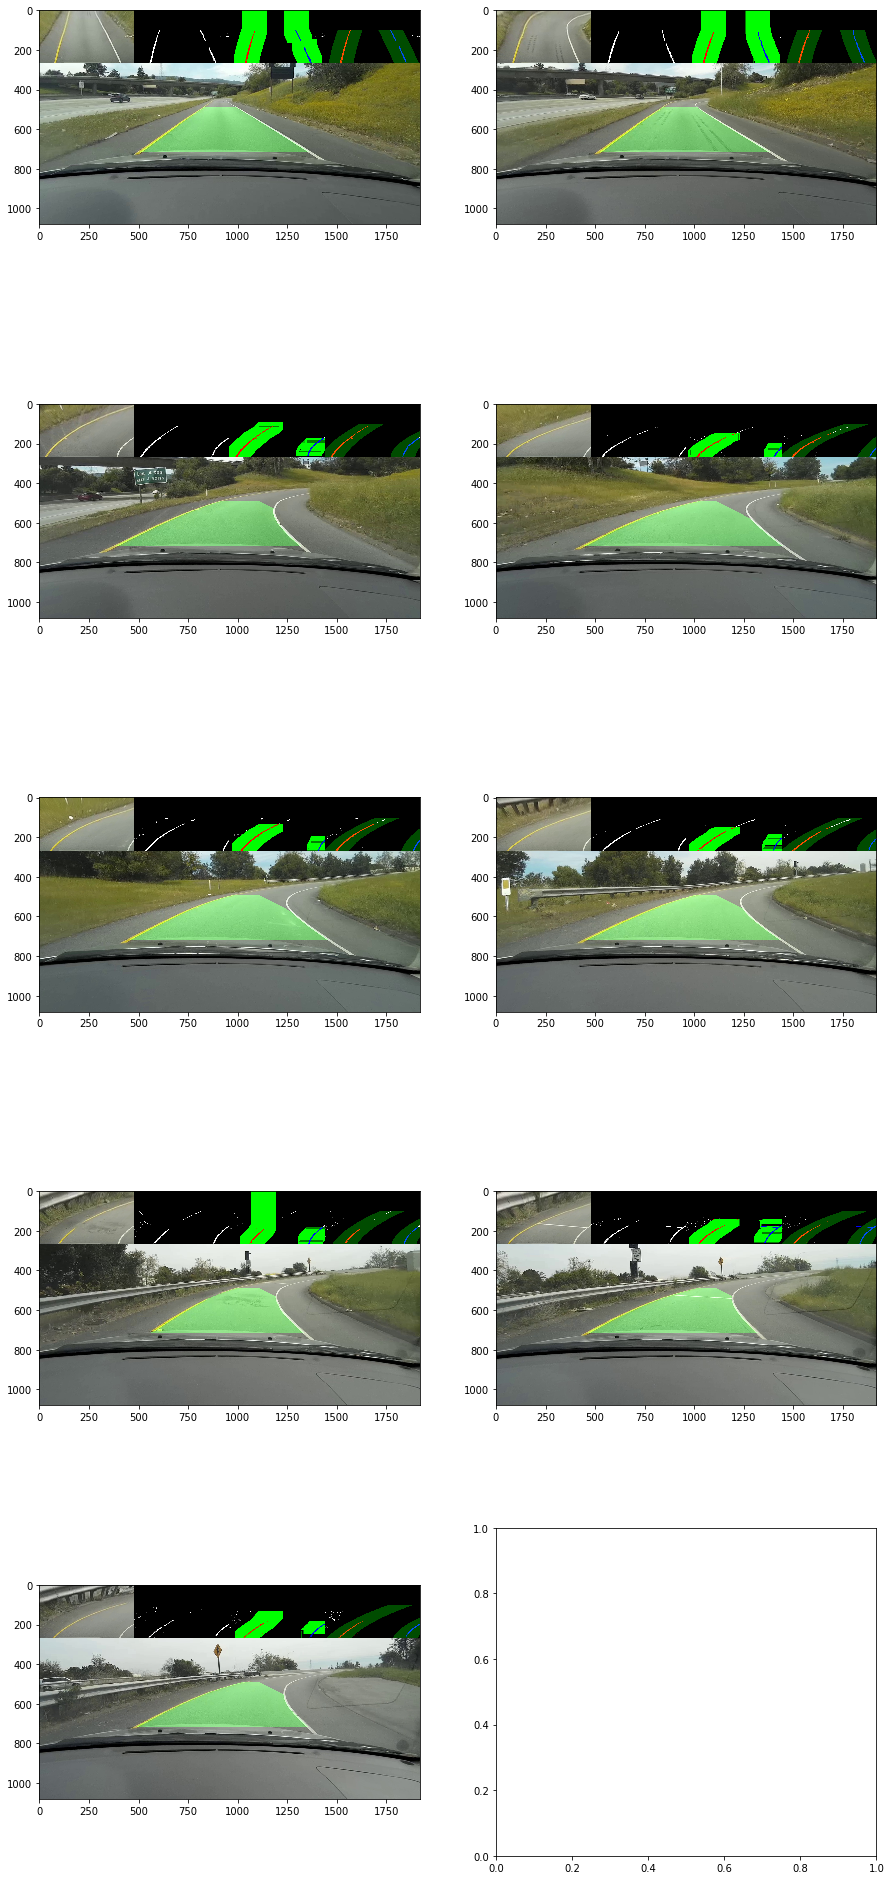

In [34]:
import time
import random
def process_image(image):
    # source points for mobius 1920x1080
    src_top_left = [790,460]
    src_bottom_left = [290,720]
    src_bottom_right = [1550,720]
    src_top_right = [1050,460]
    source_points = np.float32([src_top_left,src_bottom_left,src_bottom_right,
                     src_top_right])

    left = 0
    right = 1920
    bottom = 0
    top = 1080
    dest_top_left = [left,bottom]
    dest_bottom_left = [left,top]
    dest_bottom_right = [right,top]
    dest_top_right = [right,bottom]
    dest_points = np.float32([dest_top_left,dest_bottom_left,dest_bottom_right,
                              dest_top_right])

    
    M = cv2.getPerspectiveTransform(source_points,dest_points)
    Minv = cv2.getPerspectiveTransform(dest_points,source_points)
    # undistort image
    image = cv2.undistort(image, mtx, dist, None, mtx)
    image_undistorted = image
    birdseye_view = apply_birdseye(image_undistorted,source_points,dest_points)
    # Applying Combined Color and Gradient Thresholding to Birds Eye View Image
    combined = combined_threshold(birdseye_view, gradx_low=40, gradx_high=255, mag_low=40, mag_high=255, dir_low=0.7, dir_high=1.3, \
                       s_low=100, s_high=255, l_low=120, l_high=255,  l_agr=205, kernel_size=3)
    limit_look_ahead = 0.4
    combined = np.logical_and(combined,region_of_interest(combined,limit_look_ahead=limit_look_ahead)).astype(np.uint8)

    binary_warped = combined
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/1.35):,:], axis=0) # 1.25
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 8
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    lefty_current = image.shape[0] - window_height//2
    righty_current = image.shape[0] - window_height//2
    
    # Set the width of the windows +/- margin
    #margin =280
    margin = 250 # best is 120
    window_height = image.shape[0]//nwindows
    
  
    
    
    # Set minimum number of pixels found to recenter window
    minpix = 1000 # best is 50 (500)
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Re-center window based on both x and y position
    
    # Step through the windows one by one
    #for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        #win_y_low = binary_warped.shape[0] - (window+1)*window_height
        #win_y_high = binary_warped.shape[0] - window*window_height
        

    window = 0
    # Initialize top, bottom, left, and right boundaries of left and right search windows
    win_yleft_low = lefty_current + window_height//2
    win_yleft_high = lefty_current - window_height//2
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_yright_low = righty_current + window_height//2
    win_yright_high = righty_current - window_height//2
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Initialize the direction the left and right window searches move in
    left_dx = 0
    left_dy = -1
    right_dx = 0
    right_dy = -1
    
    # margin of wiggle room before stopping window search when it exits the side of the image
    side_margin = 1.1 #1.25
    # margin of wiggle room before stopping window search when it crosses into other half of image
    middle_margin = 1.0 # 1.0
    
    n_left_windows = 0 # Initialize the number of left windows used
    n_right_windows = 0 # Initialize the number of right windows used
    min_n_windows = 100 # min number of windows before terminating window search
    # While
    # (((left window search is within left side of image) OR (left window count is less than min_n_windows))
    # OR 
    # ((right window search is within right side of image) OR (right window count is less than min_n_windows)))
    while ((((win_xleft_low >= -1*(margin//2)*side_margin) & (win_xleft_high <= (image.shape[1]//2 + ((margin//2)*middle_margin))) & (win_yleft_high > 0)) | (n_left_windows < min_n_windows)) | \
            (((win_xright_low >= (image.shape[1]//2 - ((margin//2)*middle_margin))) & (win_xright_high <= (image.shape[1] + (margin//2)*side_margin)) & (win_yright_high > 0)) | (n_right_windows < min_n_windows))):
        #window += 1
        # Do left lane line
        # Find left, right, top, bottom, boundaries of window
        win_yleft_low = lefty_current + window_height//2
        win_yleft_high = lefty_current - window_height//2
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        #print('window number: ',window)
        # Stop performing left window search if left lane line exits left side of image
        if (((win_xleft_low >= -1*(margin//2)*side_margin) & (win_xleft_high <= image.shape[1]//2 + (margin//2)*middle_margin)) | (n_left_windows < min_n_windows)): # 1.5
            n_left_windows += 1
            # Draw window
            cv2.rectangle(out_img,(win_xleft_low,win_yleft_low),(win_xleft_high,win_yleft_high),
            (0,255,0), 2) 
            # Get indicies of nonzero pixels within window
            good_left_inds = ((nonzeroy < win_yleft_low) & (nonzeroy >= win_yleft_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            # Append these indicies to list of left lane line indicies
            left_lane_inds.append(good_left_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                #print('found minpix')
                # Always re-center x position; let new x position go to the left or right
                leftx_previous = leftx_current
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                left_dx = leftx_current - leftx_previous
                # Only re-center y position if the new center is higher up on the image than the previous center
                # higher up on the image means a smaller y value
                # 0 y value is at the top of the image
                if (np.int(np.mean(nonzeroy[good_left_inds])) < lefty_current):
                    lefty_previous = lefty_current 
                    lefty_current = np.int(np.mean(nonzeroy[good_left_inds]))
                    left_dy = lefty_current - lefty_previous
                # If the re-centering of the y position causes the window to stay in the same spot or go back down
                # then force the window to move one pixel up the image (y value goes down)
                # This way the window search does not get stuck
                # But it still moves up slowly enough that it does not miss
                # lane lines that are far apart horizontally
                else:
                    lefty_current += left_dy
            else:
                #print('didnt find minpix')
                leftx_current += left_dx
                lefty_current += left_dy
            
        
        # Do right lane line
        # Find left and right boundaries of window
        win_yright_low = righty_current + window_height//2
        win_yright_high = righty_current - window_height//2
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        area = (win_yright_low-win_yright_high)*(win_xright_high-win_xright_low)
        #print('window area: ',area)
        # Stop performing right window search if right lane line exits right side of image
        if (((win_xright_high <= image.shape[1] + (margin//2)*side_margin) & (win_xright_low >=(image.shape[1]//2 - (margin//2)*middle_margin)) | (n_right_windows < min_n_windows))): # 1.5
            n_right_windows += 1
            # Draw Window
            cv2.rectangle(out_img,(win_xright_low,win_yright_low),(win_xright_high,win_yright_high),
            (0,255,0), 2) 
            # Get indicies of nonzero pixels within window
            good_right_inds = ((nonzeroy < win_yright_low) & (nonzeroy >= win_yright_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indicies to list of right lane line indicies
            right_lane_inds.append(good_right_inds)
            # if you found > minpix pixels, recenter next window on mean x-position
            #print('len(good_right_inds): ',len(good_right_inds))
            if len(good_right_inds) > minpix: 
                rightx_previous = rightx_current
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                right_dx = rightx_current - rightx_previous
                if (np.int(np.mean(nonzeroy[good_right_inds])) < righty_current):
                    righty_previous = righty_current
                    righty_current = np.int(np.mean(nonzeroy[good_right_inds]))
                    right_dy = righty_current - righty_previous
                else:
                    #righty_current -= 1
                    righty_current += right_dy
            else:
                #righty_current -= 1
                rightx_current += right_dx
                righty_current += right_dy

    """
    # Re-center window based on x position only
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height


        
        # Do left lane line
        # Find left and right boundaries of window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        # Stop performing window search if left lane line exits left side of image
        if (win_xleft_low >= -1*(margin//2)*2): # 1.5
            # Draw window
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            # Get indicies of nonzero pixels within window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            # Append these indicies to list of left lane line indicies
            left_lane_inds.append(good_left_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            
        
        # Do right lane line
        # Find left and right boundaries of window
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Stop performing window search if right lane line exits right side of image
        if (win_xright_high <= image.shape[1] + (margin//2)*2): # 1.5
            # Draw Window
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # Get indicies of nonzero pixels within window
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indicies to list of right lane line indicies
            right_lane_inds.append(good_right_inds)
            # if you found > minpix pixels, recenter next window on mean x-position
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    """
    
    # Concatenate the arrays of indices
    if (len(left_lane_inds) > 0):
        left_lane_inds = np.concatenate(left_lane_inds)
    if (len(right_lane_inds) > 0):
        right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    left_lane_inds = np.unique(left_lane_inds) # get rid of repeats
    right_lane_inds = np.unique(right_lane_inds) # get rid of repeats
    #print('right_lane_inds: ',right_lane_inds)
    
    # Temporary fix
    if (len(left_lane_inds) > 0):
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
    else:
        leftx = []
        lefty = []
    if (len(right_lane_inds) > 0):
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
    else:
        rightx = []
        righty = []
      
    shift_green_lane_up = 1.0 # originally 1.25
    ploty = np.linspace(limit_look_ahead*image.shape[0], (binary_warped.shape[0]-1)*shift_green_lane_up, binary_warped.shape[0] )
    left_fit = [0,0,0]
    right_fit = [0,0,1920]
    n = 2 # degree of polynomial for best-fit line (2 works best)
    
    # Fit a second order polynomial to each
    # Temporary fix
    if ((len(lefty) > 0) & (len(leftx) > 0)):
        #left_fit = np.polyfit(lefty, leftx, 2)
        
        left_model = make_pipeline(PolynomialFeatures(n), RANSACRegressor(random_state=42))
        left_model.fit(lefty.reshape(-1,1), leftx)

        # getting coefficients of best-fit curve
        # for some reason the one line of code below fails to return the correct coefficients
        # it only returns 2/3 of the coefficients
        # one coefficient is always zero...
        # so I have to re-calculate the coefficients using np.polyfit()
        # we need the coefficients of the best-fit line to calculate radius of curvature
        #left_fit = left_model.named_steps['ransacregressor'].estimator_.coef_
        
        left_fitx = left_model.predict(ploty.reshape(-1,1))
        left_fit = np.polyfit(ploty,left_fitx,2)
        
    
        
    else:
        left_fit = [0,0,0]
        #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        
    if ((len(righty) > 0) & (len(rightx) > 0)):
        #right_fit = np.polyfit(righty, rightx, 2)
        
        right_model = make_pipeline(PolynomialFeatures(n), RANSACRegressor(random_state=42))
        right_model.fit(righty.reshape(-1,1), rightx)
        
        # getting coefficients of best-fit curve
        # for some reason the one line of code below fails to return the correct coefficients
        # it only returns 2/3 of the coefficients
        # one coefficient is always zero...
        # so I have to re-calculate the coefficients using np.polyfit()
        # we need the coefficients of the best-fit line to calculate radius of curvature
        #right_fit = right_model.named_steps['ransacregressor'].estimator_.coef_
        
        right_fitx = right_model.predict(ploty.reshape(-1,1))
        right_fit = np.polyfit(ploty,right_fitx,2)
        
        
    else:
        right_fit = [0,1920]
        #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Generate x and y values for plotting
    #ploty = np.linspace(limit_look_ahead*image.shape[0], (binary_warped.shape[0]-1)*1.25, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    

    # Temporary fix
    if (len(left_lane_inds) > 0):
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    if (len(right_lane_inds) > 0):
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    windows = out_img

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    # Temporary fix
    if (len(left_lane_inds) > 0):
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    if (len(right_lane_inds) > 0):
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))


    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    best_fit = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Calculating radius of curvature at bottom of picture in pixels
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])


    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    yinches_per_pix = 8/480
    xinches_per_pix = 5/640

    # Fit new polynomials to x,y in world space
    #print('length of ploty: ',len(ploty))
    #print('length of leftx: ',len(leftx))
    #print('length of rightx: ',len(rightx))
    if (((len(lefty) != 0) & (len(leftx) != 0))):
        left_fit_cr = np.polyfit(lefty*yinches_per_pix, leftx*xinches_per_pix, 2)
    else:
        left_fit_cr = [0,0,0]
    if (((len(righty) != 0) & (len(rightx) != 0))):
        right_fit_cr = np.polyfit(righty*yinches_per_pix, rightx*xinches_per_pix, 2)
    else:
        right_fit_cr = [0,0,1920*xinches_per_pix]
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*yinches_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*yinches_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m

    warped = binary_warped
    height = warped.shape[0]
    width = warped.shape[1]

    # Create an image to draw the lines on
    #warp_zero = np.zeros_like(warped).astype(np.uint8)
    warp_zero = np.zeros((int(height*1.25),width),np.uint8)
    
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

    height = image.shape[0]
    width = image.shape[1]
    vehicle_center = width/2
    left_lane_position = (left_fit[0] * (height**2)) + (left_fit[1] * height) + left_fit[2]
    right_lane_position = (right_fit[0] * (height**2)) + (right_fit[1] * height) + right_fit[2]
    actual_center = left_lane_position + (right_lane_position - left_lane_position) / 2
    vehicle_position = (actual_center - vehicle_center) * xinches_per_pix
    vehicle_position = round((vehicle_position),2)



    font = cv2.FONT_HERSHEY_SIMPLEX
    #cv2.putText(result, "Left Radius Of Curvature: " + str(round(left_curverad,0)), (50, 50), font, 1.1, (255, 255, 255), 2, cv2.LINE_AA)
    #cv2.putText(result, "Right Radius Of Curvature: " + str(round(right_curverad,0)), (50, 100), font, 1.1, (255, 255, 255), 2, cv2.LINE_AA)
    if (vehicle_position < 0):
        vehicle_position_str = str(np.absolute(vehicle_position)) + " inches right of center"
    elif (vehicle_position > 0):
        vehicle_position_str = str(np.absolute(vehicle_position)) + " inches left of center"
    else:
        vehicle_position_str =  "on center"
    #cv2.putText(result, vehicle_position_str, (50,150), font, 1.1, (255,255,255), 2, cv2.LINE_AA)
    
    height = birdseye_view.shape[0]
    width = birdseye_view.shape[1]

    birdseye_view = resize(birdseye_view, (height//4,width//4))*255
    binary_warped = resize(binary_warped, (height//4,width//4))*255
    windows = resize(windows, (height//4,width//4))*255
    best_fit = resize(best_fit, (height//4,width//4))*255


    binary_warped_color = np.zeros_like(windows)
    binary_warped_color[:,:,0] = binary_warped*255
    binary_warped_color[:,:,1] = binary_warped*255
    binary_warped_color[:,:,2] = binary_warped*255
    
    """
    offset = [0, 320, 640, 960]
    width, height = 320,180

    result[:height, offset[0]: offset[0] + width] = birdseye_view
    result[:height, offset[1]: offset[1] + width] = binary_warped_color
    result[:height, offset[2]: offset[2] + width] = windows
    result[:height, offset[3]: offset[3] + width] = best_fit
    """
    
    #offset = [0 ,160, 320, 480]
    #width, height = 160,90
    
    offset = [0, int(image.shape[1]*0.25), int(image.shape[1]*0.5), int(image.shape[1]*0.75)]
    width, height = image.shape[1]//4, image.shape[0]//4
    
    #print('result.shape: ',result.shape)
    result[:height, offset[0]: offset[0] + width] = birdseye_view
    result[:height, offset[1]: offset[1] + width] = binary_warped_color
    result[:height, offset[2]: offset[2] + width] = windows
    result[:height, offset[3]: offset[3] + width] = best_fit

    #return result,image_undistorted,best_fit,windows,left_fitx,right_fitx,ploty,binary_warped,birdseye_view
    return result



# Display all relevant images on one image for debugging
num_pictures = len(image_paths)
f,axs = plt.subplots(num_pictures//2+1,2,figsize=(15, 35))
axs = axs.ravel()

for i,image_path in enumerate(image_paths):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    t1 = time.time()
    result = process_image(image)
    t2 = time.time()
    process_time = t2-t1
    print('process_time %d: ' % i,process_time)

    
    axs[i].imshow(result)
    plt.imsave("results/%d.jpg" %  i, result)




# Display all relevant images as separate images
"""
f, axs = plt.subplots(num_pictures,5,figsize=(10,30))
axs = axs.ravel()

for i,image_path in enumerate(image_paths):
    image = mpimg.imread(image_path)
    result,image_undistorted,best_fit,windows,left_fitx,right_fitx,ploty,binary_warped = process_image(image)
    #ploty = [i for i in ploty if i <= 480*2.5]
    #length = len(ploty)
    #lift_fitx = left_fitx[:length]
    #right_fitx = right_fitx[:length]
    axs[i*5].imshow(image_undistorted)
    axs[i*5+1].imshow(binary_warped)
    axs[i*5+2].imshow(windows)
    axs[i*5+3].imshow(best_fit)
    axs[i*5+3].plot(left_fitx,ploty,color='yellow')
    axs[i*5+3].plot(right_fitx,ploty,color='orange')
    axs[i*5+4].imshow(result)
"""
